# Imports

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Loading the data

In [ ]:
# Load the data
df = pd.read_csv('data/match_alhambra_cosmos2020_ACS_class_0.8arcsec.csv')

# Load the ALHAMBRA catalog
# .cat files are typically space/whitespace delimited
alhambra_df = pd.read_csv('data/full_alhambra_V5_masksel_v6_head.cat', sep=r'\s+')

## DEA COSMOS2020

This contains the possible training sample that we discussed to start with.
It is a cross-match between the previous ALHAMBRA catalog and the 
'COSMOS2020' catalog (the reference for this catalog is [1](https://ui.adsabs.harvard.edu/abs/2022ApJS..258...11W/abstract)).


Basically, the idea would be to use as a 'label' the class that is defined
in the last column ('acs_mu_class'), which defines a separation between
'star' (point source) and 'galaxy' (extended object), according to the
method described in section 3.6 of reference [2](https://ui.adsabs.harvard.edu/abs/2007ApJS..172..219L/abstract). 

This classification is based on very deep images (I think ~2-3 magnitudes
deeper than ALHAMBRA) taken with the HST's ACS camera (therefore from
space), so it can be a good reference. 

In this file, for the ~23000
matching objects, you have the same columns from the other file
corresponding to ALHAMBRA, and some additional columns that come from
COSMOS. In principle, these additional columns could not be used in the
classification, but they can be useful for verification if necessary.


Action Plan:
1. Data Preprocessing
   - Clean the data by handling NaN values
   - Normalize/scale numerical features
   - Encode categorical variables if needed
2. Feature Selection/Engineering
   - Identify most relevant ALHAMBRA features for classification
   - Create new features if beneficial
   - Remove highly correlated features
3. Model Development
   - Split data into train/validation/test sets
   - Try different classification algorithms (RF, SVM, etc.)
   - Perform hyperparameter tuning
   - Evaluate using metrics like accuracy, precision, recall
4. Model Validation
   - Cross-validation
   - Check for overfitting
   - Analyze misclassified cases
5. Final Testing & Documentation
   - Test on holdout set
   - Document model performance
   - Create visualizations of results


In [3]:
# Get basic information about the dataframe
print("DataFrame Shape:", df.shape)
print("\nDataFrame Info:")
df.info()

# Separate numerical and categorical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

print("\nNumerical Columns:", len(numerical_cols))
print(numerical_cols.tolist())
print("\nCategorical Columns:", len(categorical_cols))
print(categorical_cols.tolist())

# Statistical summary of numerical columns
print("\nNumerical Columns Summary:")
print(df[numerical_cols].describe())

# Information about categorical columns
print("\nCategorical Columns Summary:")
for col in categorical_cols:
    print(f"\n{col}:")
    print(f"Number of unique categories: {df[col].nunique()}")
    print("All categories and their counts:")
    print(df[col].value_counts())

# NaN analysis
print("\nNaN Analysis:")
nan_counts = df.isna().sum()
print("\nColumns with NaN values:")
print(nan_counts[nan_counts > 0])

# Percentage of NaN values in each column
print("\nPercentage of NaN values in each column:")
print((df.isna().sum() / len(df) * 100)[nan_counts > 0])

# Find rows with NaN values
rows_with_nans = df[df.isna().any(axis=1)]
print(f"\nNumber of rows with at least one NaN: {len(rows_with_nans)}")

# Display first few rows with NaN values to understand the pattern
print("\nExample rows with NaN values:")
print(rows_with_nans.head())


DataFrame Shape: (27389, 136)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27389 entries, 0 to 27388
Columns: 136 entries, ID_1 to Separation
dtypes: float64(116), int64(19), object(1)
memory usage: 28.4+ MB

Numerical Columns: 135
['ID_1', 'RA_1', 'Dec_1', 'x', 'y', 'area', 'fwhm', 'stell', 'ell', 'a', 'b', 'theta', 'rk', 'rf', 's2n', 'photoflag', 'F365W', 'dF365W', 'F396W', 'dF396W', 'F427W', 'dF427W', 'F458W', 'dF458W', 'F489W', 'dF489W', 'F520W', 'dF520W', 'F551W', 'dF551W', 'F582W', 'dF582W', 'F613W', 'dF613W', 'F644W', 'dF644W', 'F675W', 'dF675W', 'F706W', 'dF706W', 'F737W', 'dF737W', 'F768W', 'dF768W', 'F799W', 'dF799W', 'F830W', 'dF830W', 'F861W', 'dF861W', 'F892W', 'dF892W', 'F923W', 'dF923W', 'F954W', 'dF954W', 'J', 'dJ', 'H', 'dH', 'KS', 'dKS', 'F814W', 'dF814W', 'F814W_3arcs', 'dF814W_3arcs', 'F814W_3arcs_corr', 'nfobs', 'xray', 'PercW', 'Satur_Flag', 'Stellar_Flag', 'zb_1', 'zb_Min_1', 'zb_Max_1', 'Tb_1', 'Odds_1', 'z_ml', 't_ml', 'Chi2', 'Stell_Mass_

## DEA ALHAMBRA CAT

Corresponds to [Molino et al.](http://adsabs.harvard.edu/abs/2014MNRAS.441.2891M)

As you can see,
if you look at the distribution in (ra, dec) it contains data in all 7 
ALHAMBRA fields. The columns in this catalog should correspond to those 
described in the Molino et al. paper (if there are any added or missing 
columns, please ask me). I'm sending you the complete catalog to have it, 
but you'll probably want to work most of the time with the labeled sample 
from the csv.


ALHAMBRA Catalog Shape: (378614, 109)

ALHAMBRA Catalog Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378614 entries, 0 to 378613
Columns: 109 entries, #ID to irms_NIR_Flag
dtypes: float64(101), int64(8)
memory usage: 314.9 MB

Numerical columns:
['#ID', 'RA', 'Dec', 'x', 'y', 'area', 'fwhm', 'stell', 'ell', 'a', 'b', 'theta', 'rk', 'rf', 's2n', 'photoflag', 'F365W', 'dF365W', 'F396W', 'dF396W', 'F427W', 'dF427W', 'F458W', 'dF458W', 'F489W', 'dF489W', 'F520W', 'dF520W', 'F551W', 'dF551W', 'F582W', 'dF582W', 'F613W', 'dF613W', 'F644W', 'dF644W', 'F675W', 'dF675W', 'F706W', 'dF706W', 'F737W', 'dF737W', 'F768W', 'dF768W', 'F799W', 'dF799W', 'F830W', 'dF830W', 'F861W', 'dF861W', 'F892W', 'dF892W', 'F923W', 'dF923W', 'F954W', 'dF954W', 'J', 'dJ', 'H', 'dH', 'KS', 'dKS', 'F814W', 'dF814W', 'F814W_3arcs', 'dF814W_3arcs', 'F814W_3arcs_corr', 'nfobs', 'xray', 'PercW', 'Satur_Flag', 'Stellar_Flag', 'zb_1', 'zb_Min_1', 'zb_Max_1', 'Tb_1', 'Odds_1', 'z_ml', 't_ml', 'Chi2', 'Stell_Mass_1'

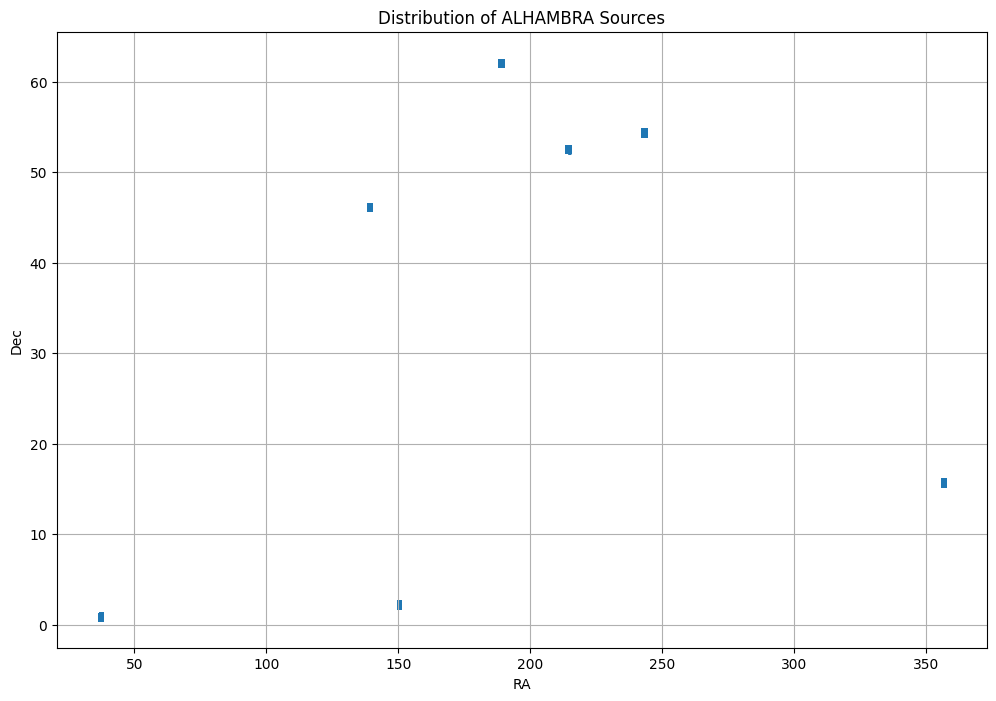

In [15]:
# Get basic information about the ALHAMBRA catalog
print("ALHAMBRA Catalog Shape:", alhambra_df.shape)
print("\nALHAMBRA Catalog Info:")
alhambra_df.info()

# Separate numerical and categorical columns
numerical_columns = alhambra_df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = alhambra_df.select_dtypes(include=['object', 'category', 'bool']).columns

print("\nNumerical columns:")
print(numerical_columns.tolist())

print("\nCategorical columns:")
print(categorical_columns.tolist())



# Basic statistics of the catalog
print("\nNumerical Columns Summary:")
print(alhambra_df.describe())

# Check distribution of RA and Dec to verify the 7 ALHAMBRA fields
print("\nRA and Dec distribution:")
print("\nRA statistics:")
print(alhambra_df['RA'].describe())
print("\nDec statistics:")
print(alhambra_df['Dec'].describe())

# Check for missing values
missing_values = alhambra_df.isnull().sum()
print(f"\nMissing values in ALHAMBRA catalog:{missing_values}")

# Display first few rows of the catalog
print("\nFirst few rows of the ALHAMBRA catalog:")
print(alhambra_df.head())


# Create a scatter plot of RA vs Dec to visualize the fields
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(alhambra_df['RA'], alhambra_df['Dec'], alpha=0.1, s=1)
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.set_title('Distribution of ALHAMBRA Sources')
ax.grid(True)
plt.show()